In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
col_names = ['Variance_WT', 'Skewness_WT', 'Curtosis_WT', 'Entropy', 'Class']
data = pd.read_csv("data_banknote_authentication_dataset.csv", skiprows=1, header=None, names=col_names)
data.head(10)

,Variance_WT,Skewness_WT,Curtosis_WT,Entropy,Class
1,3.62160,8.6661,-2.80730,-0.44699,0
2,4.54590,8.1674,-2.45860,-1.46210,0
3,3.86600,-2.6383,1.92420,0.10645,0
4,3.45660,9.5228,-4.01120,-3.59440,0
5,0.32924,-4.4552,4.57180,-0.98880,0
6,4.36840,9.6718,-3.96060,-3.16250,0
7,3.59120,3.0129,0.72888,0.56421,0
8,2.09220,-6.8100,8.46360,-0.60216,0
9,3.20320,5.7588,-0.75345,-0.61251,0
10,1.53560,9.1772,-2.27180,-0.73535,0


In [3]:
accuracy_dict = {}

In [4]:
def accuracy(y_true, y_predicted):
    accuracy = np.sum(y_true == y_predicted)/len(y_true)
    return accuracy

# Decision Tree Classifier

In [5]:
X_decision_tree = data.iloc[:, :-1].values
Y_decision_tree = data.iloc[:, -1].values
X_train_decision_tree, X_test_decision_tree, y_train_decision_tree, y_test_decision_tree = train_test_split(X_decision_tree, Y_decision_tree, test_size=.2, random_state=1234)

In [6]:
#y = all the class label
def entropy(y):
    #to calculate the number of occurence of each class label
    hist = np.bincount(y)
    ps = hist / len(y)
    
    return -np.sum([p * np.log2(p) for p in ps if p > 0])

In [7]:
class Node():
    def __init__(self, feature = None, threshold = None, left = None, right = None, *, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [8]:
class DecisionTree():
    def __init__(self, min_sample_split = 2, max_depth = 100, no_of_features = None):
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.no_of_features = no_of_features
        self.root = None
        
    def fit(self, X, y):
        self.no_of_features = X.shape[1] if not self.no_of_features else min(self.no_of_features, X.shape[1])
        self.root = self._grow_tree(X, y)
    
    def _grow_tree(self, X, y, depth = 0):
        no_of_samples, no_of_features = X.shape
        no_of_labels = len(np.unique(y))
        
        #checking for the stopping criteria
        if(depth >= self.max_depth or no_of_labels == 1 or no_of_samples < self.min_sample_split):
            leaf_value = self._most_common_label(y)
            return Node(value = leaf_value)
        
        #Selecting an array of feature indices randomly from the given features
        feature_index = np.random.choice(no_of_features, self.no_of_features, replace = False)
        
        #greedy search for best splitting criteria
        best_feature, best_threshold = self._best_criteria(X, y, feature_index)
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_index, split_threshold = None, None
        
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_index = feat_idx
                    split_threshold = threshold
                    
        return split_index, split_threshold
    
    def _information_gain(self, y, X_column, split_threshold):
        #calculate the parents entropy
        parent_entropy = entropy(y)
        
        #generate split
        left_idxs, right_idxs = self._split(X_column, split_threshold)
        
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        #calculate [weighted average]E(children)
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l/n)*e_l + (n_r/n)*e_r
        
        #return information gain = E(parent) - [weighted average]E(children)
        information_gain = parent_entropy - child_entropy
        
        return information_gain
        
    def _split(self, X_column, split_threshold):
        #gives an array of all the indices in X_column that follow the splitting criteria
        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        
        return left_idxs, right_idxs
        
    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common
        
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        
        return self._traverse_tree(x, node.right)

In [9]:
Decision_Tree_Classifier = DecisionTree(max_depth = 10)
Decision_Tree_Classifier.fit(X_train_decision_tree, y_train_decision_tree)
y_predicted_decision_tree = Decision_Tree_Classifier.predict(X_test_decision_tree)
accuracy_decision_tree = accuracy(y_test_decision_tree, y_predicted_decision_tree)

accuracy_dict[1] = ["Decision Tree", accuracy_decision_tree]
print("Accuracy of Decision Tree:", accuracy_decision_tree)

Accuracy of Decision Tree: 0.9927272727272727


# KNN Classifier

In [10]:
X_KNN = data.iloc[:,:4].values
y_KNN = data.iloc[:,-1].values
X_train_KNN, X_test_KNN, y_train_KNN, y_test_KNN = train_test_split(X_KNN, y_KNN, test_size = 0.2, random_state = 1234)

In [11]:
def euclidean_distance(x1, x2):
  return np.sqrt(np.sum(x1 - x2)**2)

In [12]:
class KNN:
  def __init__(self, k = 3):
    self.k = k

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X):
    predicted_labels = [self._predict(x) for x in X]
    return np.array(predicted_labels)

  def _predict(self, x):
    distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
    k_indices = np.argsort(distances)[:self.k]
    k_nearest_labels = [self.y_train[i] for i in k_indices]
    most_common = Counter(k_nearest_labels).most_common(1)
    return most_common[0][0]

## For k = 3

In [13]:
KNN_Classifier_3 = KNN(k = 3)
KNN_Classifier_3.fit(X_train_KNN, y_train_KNN)
y_predicted_KNN_3 = KNN_Classifier_3.predict(X_test_KNN)

accuracy_KNN_3 = accuracy(y_test_KNN, y_predicted_KNN_3)

accuracy_dict[2] = ["KNN (k = 3)", accuracy_KNN_3]
print("Accuracy for k = 3 is :", accuracy_KNN_3)

Accuracy for k = 3 is : 0.96


## For k = 5 

In [14]:
KNN_Classifier_5 = KNN(k = 5)
KNN_Classifier_5.fit(X_train_KNN, y_train_KNN)
y_predicted_KNN_5 = KNN_Classifier_5.predict(X_test_KNN)

accuracy_KNN_5 = accuracy(y_test_KNN, y_predicted_KNN_5)

accuracy_dict[3] = ["KNN (k = 5)", accuracy_KNN_5]
print("Accuracy of KNN for k = 5 is :", accuracy_KNN_5)

Accuracy of KNN for k = 5 is : 0.9563636363636364


# Random Forest Classifier

In [15]:
X_random_forest = data.iloc[:, :-1].values
Y_random_forest = data.iloc[:, -1].values
X_train_random_forest, X_test_random_forest, y_train_random_forest, y_test_random_forest = train_test_split(X_random_forest, Y_random_forest, test_size=.2, random_state=1234)

In [16]:
def bootstrap_sample(X, y):
    no_of_samples = X.shape[0] 
    indices = np.random.choice(no_of_samples, size=no_of_samples, replace=True)
    
    return X[indices], y[indices]

In [17]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [18]:
class RandomForest():
    def __init__(self, no_of_trees=100, min_sample_split=2, max_depth=100, no_of_features=None):
        self.no_of_trees = no_of_trees
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.no_of_features = no_of_features
        self.trees = []
    
    def fit(self, X, y):
        self.trees = []
        for _ in range(self.no_of_trees):
            tree = DecisionTree(min_sample_split = self.min_sample_split, max_depth = self.max_depth, no_of_features = self.no_of_features)
            X_sample, y_sample = bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            
    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_predictions = np.swapaxes(tree_predictions, 0, 1)
        
        y_predictions = [most_common_label(tree_prediction) for tree_prediction in tree_predictions]
        
        return np.array(y_predictions)

In [19]:
Random_Forest_Classifier = RandomForest(no_of_trees = 3)
Random_Forest_Classifier.fit(X_train_random_forest, y_train_random_forest)
y_predicted_random_forest = Random_Forest_Classifier.predict(X_test_random_forest)

accuracy_random_forest = accuracy(y_test_random_forest, y_predicted_random_forest)

accuracy_dict[4] = ["Random Forest", accuracy_random_forest]
print("Accuracy of Random Forest Classifier is :", accuracy_random_forest)

Accuracy of Random Forest Classifier is : 0.9963636363636363


# Support Vector Machine

In [24]:
X_svm = data.iloc[:, :-1].values
y_svm = data.iloc[:, -1].values
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_svm, y_svm, test_size=.2, random_state=1234)
y_svm = np.where(y_svm == 0, -1, 1)

In [25]:
class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

    def accuracy(y_true, y_predicted):
      accuracy = np.sum(y_true == y_predicted)/len(y_true)
      return accuracy

[-0.83801443 -0.55370296 -0.62163626  0.0096558 ] -1.3719999999999597


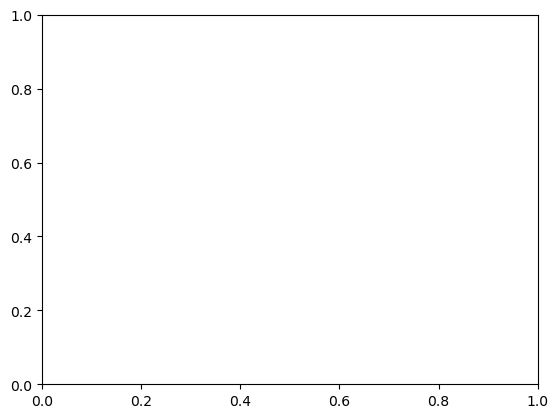

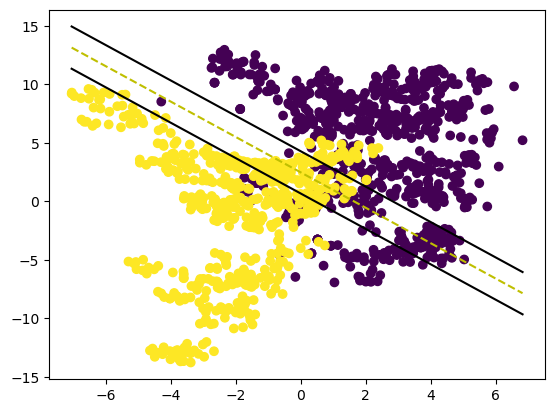

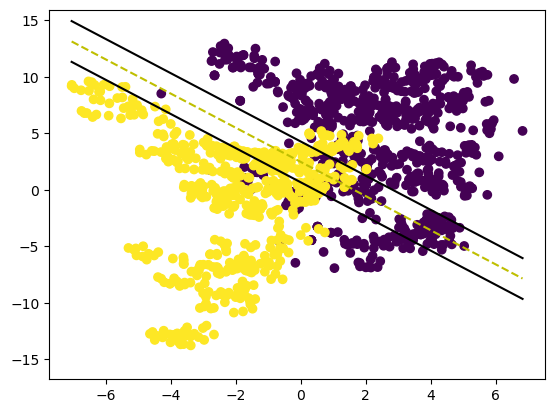

In [33]:
clf = SVM()
clf.fit(X_train_svm, y_train_svm)
# predictions = clf.predict(X)

print(clf.w, clf.b)

def visualize_svm():
    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X_svm[:, 0], X_svm[:, 1], marker="o", c=y_svm)

    x0_1 = np.amin(X_svm[:, 0])
    x0_2 = np.amax(X_svm[:, 0])

    x1_1 = get_hyperplane_value(x0_1, clf.w, clf.b, 0)
    x1_2 = get_hyperplane_value(x0_2, clf.w, clf.b, 0)

    x1_1_m = get_hyperplane_value(x0_1, clf.w, clf.b, -1)
    x1_2_m = get_hyperplane_value(x0_2, clf.w, clf.b, -1)

    x1_1_p = get_hyperplane_value(x0_1, clf.w, clf.b, 1)
    x1_2_p = get_hyperplane_value(x0_2, clf.w, clf.b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X_svm[:, 1])
    x1_max = np.amax(X_svm[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()

visualize_svm()

In [27]:
SVM_Classifier = SVM()
SVM_Classifier.fit(X_train_svm, y_train_svm)
y_predicted_svm = SVM_Classifier.predict(X_test_svm)

accuracy_svm = accuracy(y_test_svm, y_predicted_svm)

accuracy_dict[5] = ["Support Vector Machine", accuracy_svm]
print("Accuracy of SVM Classifier is :", accuracy_svm)

Accuracy of SVM Classifier is : 0.41818181818181815


In [36]:
print ("{:<15} {:<25} {}".format("Sr. No.", "Algorithm", "Accuracy"))

for key, value in accuracy_dict.items():
    algorithm, accuracy = value
    print ("{:<15} {:<25} {}%".format(key, algorithm, round(accuracy*100, 2)))

Sr. No.         Algorithm                 Accuracy
1               Decision Tree             99.27%
2               KNN (k = 3)               96.0%
3               KNN (k = 5)               95.64%
4               Random Forest             99.64%
5               Support Vector Machine    41.82%
